In [1]:
import torch
from safetensors.numpy import load_file

path = "/mnt/ssd-1/gpaulo/SAE-Zoology/raw_features/gemma/131k/.model.layers.24/0_26213.safetensors"
x = load_file(path)

In [2]:
x["activations"].shape

(103855983,)

In [3]:
x["locations"][0]

array([   0,    1, 4510], dtype=uint16)

In [28]:
from sae_auto_interp.config import ExperimentConfig, FeatureConfig
from sae_auto_interp.features import (
    FeatureDataset,
    FeatureLoader
)
from sae_auto_interp.features.constructors import default_constructor
from sae_auto_interp.features.samplers import sample

sae_model = "gemma/131k"
module = ".model.layers.24"
feature_dict = {f"{module}": torch.arange(0, 300)}
feature_cfg = FeatureConfig(width=131072, n_splits=5, max_examples=100000, min_examples=200)
experiment_cfg = ExperimentConfig(n_random=0, example_ctx_len=64, n_quantiles=5, n_examples_test=0, n_examples_train=3, train_type="quantiles", test_type="even")

In [29]:
from sae_auto_interp.features import FeatureDataset
from functools import partial

dataset = FeatureDataset(
        raw_dir=f"/mnt/ssd-1/gpaulo/SAE-Zoology/raw_features/{sae_model}",
        cfg=feature_cfg,
        modules=[module],
        features=feature_dict,
)

constructor=partial(
            default_constructor,
            tokens=dataset.tokens,
            n_random=experiment_cfg.n_random, 
            ctx_len=experiment_cfg.example_ctx_len, 
            max_examples=feature_cfg.max_examples
        )

sampler=partial(sample,cfg=experiment_cfg)
loader = FeatureLoader(dataset, constructor=constructor, sampler=sampler)
    
    

EleutherAI/rpj-v2-sample  train[:1%]


In [30]:
record = next(iter(loader))
record

In [35]:
record.feature

.model.layers.24_feature0

AttributeError: 'FeatureRecord' object has no attribute 'test'

In [5]:
import torch
from transformers import GPT2Tokenizer, GPT2Model
import json
from tqdm import tqdm

# Load GPT-2 model and tokenizer
model = GPT2Model.from_pretrained('gpt2')
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

# Function to get hidden states for a single text
def get_hidden_states(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, max_length=1024)
    with torch.no_grad():
        outputs = model(**inputs, output_hidden_states=True)
    return outputs.hidden_states[5].squeeze(0)  # Layer 8

# Initialize list to store hidden states
all_hidden_states = []

# Read and process 10 samples from pile.jsonl
with open('pile.jsonl', 'r') as file:
    for i, line in enumerate(tqdm(file, total=10)):
        if i >= 100:
            break
        data = json.loads(line)
        text = data['text']
        hidden_states = get_hidden_states(text)
        all_hidden_states.append(hidden_states)

# Calculate average hidden state
avg_hidden_state = torch.mean(torch.stack([hs.mean(dim=0) for hs in all_hidden_states]), dim=0)
std_hidden_state = torch.std(torch.stack([hs.mean(dim=0) for hs in all_hidden_states]), dim=0)

print("Shape of average hidden state:", avg_hidden_state.shape)
print("Average hidden state:", avg_hidden_state)
print("Standard deviation of hidden state:", std_hidden_state)

/home/alex/.local/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
100it [00:15,  6.44it/s]                       


Shape of average hidden state: torch.Size([768])
Average hidden state: tensor([-1.5597e-02,  1.9991e-01, -3.0909e-01, -2.1394e-01, -8.1219e-02,
         1.7844e-01,  4.5589e-01, -3.4884e-01,  2.1072e-01,  1.6034e-01,
        -4.3308e-02,  9.5965e-02, -1.1289e-01,  2.6585e-02, -1.4579e+00,
         1.1589e-01, -3.1624e-01, -1.8671e-01,  2.9398e-01,  4.5797e-02,
        -2.8800e-01, -2.8639e-01,  2.1256e-01,  1.3595e-01,  2.5718e-02,
        -1.9786e-01,  4.2287e-01, -1.6298e-01,  8.3939e-02,  2.5981e-01,
        -3.2666e-02,  6.1304e-01,  3.7338e-01, -2.5341e-02, -1.4184e-01,
        -1.2185e+00,  1.4762e-01,  2.0000e-02, -2.1953e-01,  2.8143e-01,
         1.2926e-01, -1.0644e-01,  9.5938e-02,  3.9441e-02, -5.3910e-02,
        -2.3664e-01,  1.2989e-01,  2.9985e-02,  2.8127e-01,  9.2150e-02,
         2.8226e-01,  4.6701e-02, -3.3332e-03,  1.1925e-01, -2.1657e-01,
        -1.1618e-01,  5.8302e-02, -3.9445e-03, -2.9537e-01, -6.3671e-01,
         1.6072e-02, -7.9600e-02, -2.9425e-01,  2.513

In [42]:
torch.topk(torch.stack([h for hs in all_hidden_states for h in hs]), k=1)

torch.return_types.topk(
values=tensor([[2742.2388],
        [  40.2631],
        [  40.1337],
        ...,
        [  26.1541],
        [  14.5867],
        [  23.3634]]),
indices=tensor([[447],
        [447],
        [447],
        ...,
        [447],
        [326],
        [447]]))

In [31]:
avg_hidden_states = torch.mean(torch.stack([h for hs in all_hidden_states for h in hs]), dim=1)

In [47]:
num_stds_over_0 = avg_hidden_state / std_hidden_state
num_stds_over_0[288]

tensor(3.4529)

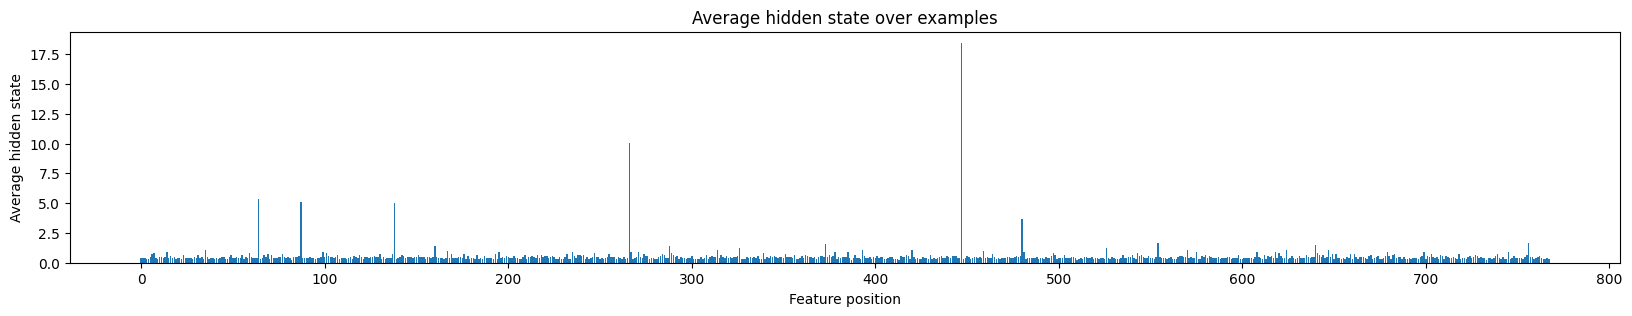

In [49]:
plt.figure(figsize=(20, 3), dpi=100)
plt.bar(range(len(std_hidden_state)), std_hidden_state)
plt.title("Average hidden state over examples")
plt.xlabel("Feature position")
plt.ylabel("Average hidden state")
plt.show()

Text(0.5, 1.0, 'Distribution of mean_over_features(hidden state) over examples')

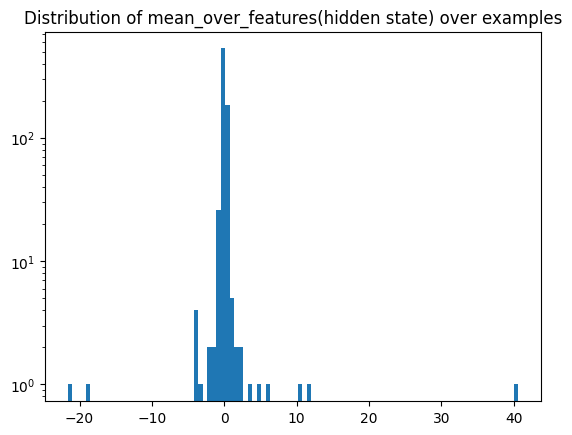

In [33]:
plt.hist(avg_hidden_state, bins=100)
plt.semilogy()
plt.title("Distribution of mean_over_features(hidden state) over examples")

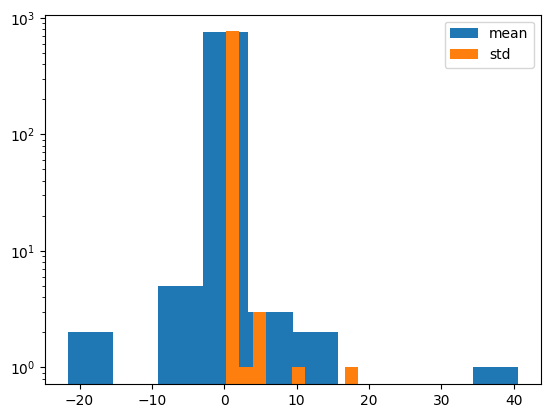

In [12]:
import matplotlib.pyplot as plt
plt.hist(avg_hidden_state, label="mean")
plt.hist(std_hidden_state, label="std")
plt.semilogy()
plt.legend()
plt.show()

In [1]:
"""
PROMPT We're studying neurons in a neural network.
Each neuron looks for some particular thing in a short document.
Look at summary of what the neuron does, and try to predict how it will fire on each token.

The activation format is token<tab>activation, activations go from 0 to 10, "unknown" indicates an unknown activation. Most activations will be 0.


Neuron 1
Explanation of neuron 1 behavior: the main thing this neuron does is find present tense verbs ending in 'ing'
Activations: 
<start>
t       unknown
urt     unknown
ur      unknown
ro      unknown
 is     unknown
 fab    unknown
ulously unknown
 funny  unknown
 and    unknown
 over   unknown
 the    0
 top    0
 as     0
 a      0
 '      0
very    0
 sneaky 0
'       1
 but    0
ler     0
 who    0
 excel  0
s       0
 in     0
 the    0
 art    0
 of     0
 impossible     0
 disappearing   6
/       0
re      0
app     0
earing  10
 acts   0
<end>
<start>
esc     unknown
aping   unknown
 the    unknown
 studio 0
 ,      0
 pic    0
col     0
i       0
 is     0
 warm   0
ly      0
 affecting      3
 and    0
 so     0
 is     0
 this   0
 ad     0
roit    0
ly      0
 minimalist     0
 movie  0
 .      0
<end>



Neuron 2
Explanation of neuron 2 behavior: the main thing this neuron does is find words related to physical medical conditions
Activations: 
<start>
as      unknown
 sac    unknown
char    unknown
ine     unknown
 movies unknown
 go     0
 ,      0
 this   0
 is     0
 likely 0
 to     0
 cause  0
 massive        0
 cardiac        0
 arrest 10
 if     0
 taken  0
 in     0
 large  0
 doses  0
 .      0
<end>
<start>
shot    unknown
 perhaps        unknown
 '      unknown
art     unknown
istically       unknown
'       unknown
 with   unknown
 handheld       unknown
 cameras        unknown
 and    unknown
 apparently     unknown
 no     unknown
 movie  unknown
 lights unknown
 by     unknown
 jo     unknown
aquin   unknown
 b      unknown
aca     unknown
-       unknown
as      0
ay      0
 ,      0
 the    0
 low    0
-       0
budget  0
 production     0
 swings 0
 annoy  0
ingly   0
 between        0
 vert   0
igo     9
 and    0
 opacity        0
 .      0
<end>



Neuron 3
Explanation of neuron 3 behavior: the main thing this neuron does is find phrases related to community
Activations: 
<start>
the     0
 sense  0
 of     0
 together       3
ness    7
 in     0
 our    0
 town   1
 is     0
 strong 0
 .      0
<end>
<start>
a       unknown
 buoy   unknown
ant     unknown
 romantic       unknown
 comedy unknown
 about  unknown
 friendship     unknown
 ,      unknown
 love   unknown
 ,      unknown
 and    0
 the    0
 truth  0
 that   0
 we     2
're     4
 all    3
 in     7
 this   10
 together       5
 .      0
<end>



Neuron 4
Explanation of neuron 4 behavior: the main thing this neuron does is find The words "everybody" and "somebody", as well as the prefix "ifty" in words like "fifty" and "thrifty".
Activations: 
<start>
 gr     unknown
ud      unknown
ges     unknown
.       unknown
 Everybody      unknown
 is     unknown
 sick   unknown
 of     unknown
 losing unknown
 so     unknown
 something      unknown
 has    unknown
 got    unknown
 to     unknown
 change unknown
 and    unknown
 we     unknown
've     unknown
 got    unknown
 to     unknown
<end>""".__len__()

3298

In [7]:
from sae_auto_interp.clients.local import Local

In [15]:
import torch
from pathlib import Path
from tqdm import tqdm

dir = "/mnt/ssd-1/gpaulo/SAE-Zoology/raw_features_small"
to_dir = "/mnt/ssd-1/alexm/sae-auto-interp/raw_features_small_100"

for i in tqdm(range(12)):
    acts = torch.load(Path(dir) / f".transformer.h.{i}_activations.pt")
    locs = torch.load(Path(dir) / f".transformer.h.{i}_locations.pt")
    mask = torch.zeros(locs.shape[0], dtype=torch.bool, device=locs.device)
    for doc_id in doc_ids:
        mask |= (locs[:, 0] == doc_id)

    print(acts.shape, locs.shape)
    acts = acts[mask]
    locs = locs[mask]

    Path(to_dir).mkdir(parents=True, exist_ok=True)
    torch.save(acts, Path(to_dir) / f".transformer.h.{i}_activations.pt")
    torch.save(locs, Path(to_dir) / f".transformer.h.{i}_locations.pt")

  0%|          | 0/12 [00:00<?, ?it/s]

torch.Size([319946752]) torch.Size([319946752, 3])


  8%|▊         | 1/12 [00:18<03:19, 18.14s/it]

torch.Size([319946752]) torch.Size([319946752, 3])


 17%|█▋        | 2/12 [00:39<03:20, 20.02s/it]

torch.Size([319946752]) torch.Size([319946752, 3])


 25%|██▌       | 3/12 [01:05<03:26, 22.97s/it]

torch.Size([319321856]) torch.Size([319321856, 3])


 33%|███▎      | 4/12 [01:33<03:18, 24.85s/it]

torch.Size([319946752]) torch.Size([319946752, 3])


 42%|████▏     | 5/12 [01:58<02:54, 24.91s/it]

torch.Size([319946752]) torch.Size([319946752, 3])


 50%|█████     | 6/12 [02:21<02:24, 24.16s/it]

torch.Size([319946752]) torch.Size([319946752, 3])


 58%|█████▊    | 7/12 [02:43<01:58, 23.64s/it]

torch.Size([319946752]) torch.Size([319946752, 3])


 67%|██████▋   | 8/12 [03:08<01:35, 23.86s/it]

torch.Size([319946752]) torch.Size([319946752, 3])


 75%|███████▌  | 9/12 [03:30<01:10, 23.46s/it]

torch.Size([319946752]) torch.Size([319946752, 3])


 83%|████████▎ | 10/12 [03:57<00:48, 24.32s/it]

torch.Size([319946752]) torch.Size([319946752, 3])


 92%|█████████▏| 11/12 [04:24<00:25, 25.23s/it]

torch.Size([319946752]) torch.Size([319946752, 3])


100%|██████████| 12/12 [04:48<00:00, 24.04s/it]


In [11]:
unq_docs = locs[:, 0].unique()
doc_ids = unq_docs[torch.randperm(len(unq_docs))[:100]]

In [12]:
doc_ids

tensor([101349,  29413, 125705,  73835,  52939, 145039,   4404,  55661,   9918,
         24270,  23055,  84188, 152561,  10548,  17811,  57152,  64676, 107807,
        151508,  15560, 147384,  46934,  42903,  36847,  42751,  78344,  92790,
        130456, 136786,  57101,  16977, 103945,   6186,  79273, 142734, 104237,
         94164,  79059,  45354,   7114,   1415,  51283,  33558, 128410,  62507,
        154007,  16198,  50643, 106148,  67986,  61115,  38900, 112472, 135565,
        155764,  96492,  25015,  77283,  61304,   6112,  18329,  28222, 147504,
         45090,  20943, 120772, 127039,  93473,  28870,  35071, 148629,  73410,
        152587,   9854, 119351,   3143, 127898,  31417,  42057,  40011,  56492,
         68011, 115601, 142962,  43419,  53236, 129214,  97671, 129682, 148212,
          5068,  85924, 138182,   3414,  28572, 110296,  41049,  64379,   8470,
         79833])

In [ ]:
from vllm import LLM, SamplingParams
import torch

# Initialize the model
llm = LLM(model="meta-llama/Meta-Llama-3-8B")  # Replace with your desired model

# Define your prompt
prompt = "The quick brown fox"

# Create a sampling params object with zero new tokens
sampling_params = SamplingParams(temperature=1.0, max_tokens=0)

# Get the outputs
outputs = llm.generate([prompt], sampling_params)

# Access the internal LLM model
model = llm.llm_engine.workers[0].model

# Tokenize the input
input_ids = llm.llm_engine.tokenizer.encode(prompt, return_tensors="pt").to(model.device)

# Forward pass through the model
with torch.no_grad():
    outputs = model(input_ids, output_hidden_states=True)

# Get the last hidden states
last_hidden_states = outputs.hidden_states[-1]

# Get the logits for each position
logits = model.lm_head(last_hidden_states)

# Print the logits shape
print(f"Logits shape: {logits.shape}")

# Optionally, print logits for a specific position
position = 0  # Change this to get logits for different positions
print(f"Logits for position {position}:")
print(logits[0, position, :10])  # Print first 10 logits for brevity

In [6]:
def read_idx_file(file_path):
    with open(file_path, 'rb') as file:
        # Read the file in binary mode
        content = file.read()
        
    # Print the first few bytes as hexadecimal
    print("First 20 bytes:", content[:20].hex())
    
    # You might need to implement specific parsing logic here
    # based on the file's structure

file_path = '/mnt/ssd-1/nora/pile.idx'
read_idx_file(file_path)

In [24]:
from pathlib import Path
import json
import os

paths = Path("/mnt/ssd-1/pile").glob("*.jsonl")

keep = []
for path in paths:
    with open(path, "r") as file:
        for line in file:
            datum = json.loads(line)
            if datum["meta"]["pile_set_name"] in ["ArXiv"]: #, "PubMed Abstracts", "StackExchange"]:
                keep.append(datum)

In [25]:
len(keep)

713001

In [26]:
save_path = f"train_pile_arxiv_{len(keep)}.jsonl"
with open(save_path, "w") as file:
    for datum in keep:
        file.write(json.dumps(datum) + "\n")

In [11]:
import pandas as pd

df = pd.read_json("pile.jsonl", lines=True)
df["meta"].value_counts() / len(df)

meta
{'pile_set_name': 'Pile-CC'}              0.245922
{'pile_set_name': 'OpenWebText2'}         0.155588
{'pile_set_name': 'StackExchange'}        0.139516
{'pile_set_name': 'PubMed Abstracts'}     0.139148
{'pile_set_name': 'Github'}               0.085419
{'pile_set_name': 'Wikipedia (en)'}       0.081418
{'pile_set_name': 'USPTO Backgrounds'}    0.053044
{'pile_set_name': 'PubMed Central'}       0.027843
{'pile_set_name': 'FreeLaw'}              0.023729
{'pile_set_name': 'ArXiv'}                0.011338
{'pile_set_name': 'DM Mathematics'}       0.009349
{'pile_set_name': 'NIH ExPorter'}         0.008501
{'pile_set_name': 'HackerNews'}           0.007542
{'pile_set_name': 'Enron Emails'}         0.004411
{'pile_set_name': 'OpenSubtitles'}        0.002893
{'pile_set_name': 'YoutubeSubtitles'}     0.001519
{'pile_set_name': 'Books3'}               0.001402
{'pile_set_name': 'EuroParl'}             0.000620
{'pile_set_name': 'PhilPapers'}           0.000298
{'pile_set_name': 'Gutenbe